In [2]:
# Import necessary libraries
import io
import base64
import numpy as np
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.graph_objects as go
from PIL import Image
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm
import random
import umap
from anomaly_detection.config.config_handler import get_config
from anomaly_detection.training.train import train_model
from anomaly_detection.models.cvae3d import CVAE3D
from anomaly_detection.data.data_loader_V2 import EELSDataset, get_data_loader
from anomaly_detection.config.config_handler import get_config

# Load your configuration
config = get_config('/home/ssulta24/Desktop/VCAE_new/anomaly_detection/config/config.yaml')

# Load your pretrained model V2
model = CVAE3D(config).to("cuda")
model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20241006_160824-x3tu4esv/files/best_model.pth', map_location="cuda")) # best loss 
model.eval()

data = EELSDataset(config)
dataset = data.get_training_sub_images()
dataset = dataset.squeeze(axis=1)
dataset.shape

anom_dataset = data.get_anomaly_sub_images()
anom_dataset = anom_dataset.squeeze(axis=1)
anom_dataset.shape

energy_values = data.get_cropped_energy_values()
print(f"Energy range: {energy_values[0]} to {energy_values[-1]} eV, Length: {len(energy_values)}")

/tmp/ipykernel_69433/1714733028.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20241006_160

WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
Energy range: 423.30001682043076 to 816.6000324487686 eV, Length: 1312


In [3]:
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy.signal import fftconvolve
import matplotlib.colors as mcolors

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def find_peaks(spectrum, prominence=0.1, distance=1, plot=False):
    """
    Find peaks in the spectrum using scipy's find_peaks function.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    prominence (float): Minimum prominence of the peaks (relative to the maximum intensity)
    distance (int): Minimum distance between peaks
    plot (bool): If True, plot the spectrum with detected peaks
    
    Returns:
    tuple: (peak_positions, peak_properties)
    """
    prominence = prominence * np.max(spectrum)
    peaks, properties = signal.find_peaks(spectrum, prominence=prominence, distance=distance)
    
    if plot:
        plot_spectrum_with_peaks(spectrum, peaks, properties)
    
    return peaks, properties

def plot_spectrum_with_peaks(spectrum, peaks, properties):
    """
    Plot the spectrum with detected peaks.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    peaks (numpy.ndarray): Array of peak indices
    properties (dict): Properties of the peaks
    """
    plt.figure(figsize=(12, 6))
    plt.plot(spectrum)
    plt.plot(peaks, spectrum[peaks], "x")
    
    # Highlighting the most prominent peak
    most_prominent = peaks[np.argmax(properties['prominences'])]
    plt.plot(most_prominent, spectrum[most_prominent], "o", color='red', markersize=10)
    
    plt.title("Spectrum with Detected Peaks (Red circle: Most Prominent)")
    plt.xlabel("Channel")
    plt.ylabel("Intensity")
    plt.show()

def find_main_peak(spectrum, plot=False):
    """
    Find the main peak in the spectrum based on highest prominence.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    plot (bool): If True, plot the spectrum with the main peak
    
    Returns:
    int: The index of the main peak
    """
    peaks, properties = find_peaks(spectrum, prominence=0.1, distance=10)
    if len(peaks) == 0:
        main_peak = np.argmax(spectrum)
    else:
        # Select the peak with the highest prominence
        main_peak = peaks[np.argmax(properties['prominences'])]
    
    if plot:
        plot_spectrum_with_peaks(spectrum, [main_peak], {'prominences': [properties['prominences'][np.argmax(properties['prominences'])]]})
    
    return main_peak

def inject_controlled_anomalies(image, anomaly_specs):
    """
    Inject controlled anomalies into the EELS image.
    
    Args:
    image (numpy.ndarray): Input image of shape (height, width, energy_channels)
    anomaly_specs (list): List of tuples specifying anomalies: (type, count, cluster_size)
    
    Returns:
    tuple: (anomalous_image, anomaly_mask)
    """
    anomalous_image = np.copy(image)
    height, width, _ = image.shape
    anomaly_mask = np.zeros((height, width), dtype=int)
    
    anomaly_funcs = {
        'peak_shift': peak_shift,
        'peak_broadening': peak_broadening,
        'intensity_fluctuation': intensity_fluctuation,
        'background_slope': background_slope,
        'noise_injection': noise_injection,
        'multiple_scattering': multiple_scattering,
        'cosmic_ray': cosmic_ray
    }
    
    anomaly_colors = {
        'peak_shift': 1,
        'peak_broadening': 2,
        'intensity_fluctuation': 3,
        'background_slope': 4,
        'noise_injection': 5,
        'multiple_scattering': 6,
        'cosmic_ray': 7
    }
    
    for anomaly_type, count, cluster_size in anomaly_specs:
        for _ in range(count):
            if anomaly_type == 'cosmic_ray':
                # For cosmic ray, we only affect a single pixel
                while True:
                    y = np.random.randint(0, height)
                    x = np.random.randint(0, width)
                    if anomaly_mask[y, x] == 0:
                        anomaly_mask[y, x] = anomaly_colors[anomaly_type]
                        anomalous_image[y, x] = anomaly_funcs[anomaly_type](anomalous_image[y, x])
                        break
            else:
                # For other anomaly types, we use clusters
                available_positions = set((y, x) for y in range(cluster_size, height - cluster_size)
                                             for x in range(cluster_size, width - cluster_size))
            
                for _ in range(count):
                    if not available_positions:
                        print(f"Warning: Not enough space to place all {anomaly_type} anomalies.")
                        break
                    
                    center_y, center_x = available_positions.pop()
                    y_start, y_end = center_y - cluster_size // 2, center_y + cluster_size // 2
                    x_start, x_end = center_x - cluster_size // 2, center_x + cluster_size // 2
                    
                    anomaly_mask[y_start:y_end, x_start:x_end] = anomaly_colors[anomaly_type]
                    for y in range(y_start, y_end):
                        for x in range(x_start, x_end):
                            anomalous_image[y, x] = anomaly_funcs[anomaly_type](anomalous_image[y, x])
                    
                    # Remove nearby positions from available_positions
                    for dy in range(-cluster_size, cluster_size + 1):
                        for dx in range(-cluster_size, cluster_size + 1):
                            nearby_y, nearby_x = center_y + dy, center_x + dx
                            if (nearby_y, nearby_x) in available_positions:
                                available_positions.remove((nearby_y, nearby_x))
        
    return anomalous_image, anomaly_mask

def peak_shift(spectrum, max_shift=80): # WORKS WELL 
    peak_pos = find_main_peak(spectrum)
    # shift = np.random.randint(-max_shift, max_shift + 1)
    shift = 100
    window = slice(max(0, peak_pos - 35), min(len(spectrum), peak_pos + 36))
    shifted_spectrum = np.roll(spectrum[window], shift)
    spectrum[window] = shifted_spectrum
    return spectrum

def peak_broadening(spectrum, max_sigma=5): # WORKS OK
    peak_pos = find_main_peak(spectrum)
    window_size = 51  # Adjust this value based on your typical peak widths
    window = slice(max(0, peak_pos - window_size//2), min(len(spectrum), peak_pos + window_size//2 + 1))
    peak_region = spectrum[window]
    sigma = np.random.uniform(0, max_sigma)
    x = np.arange(-window_size//2, window_size//2 + 1)
    gaussian = np.exp(-x**2 / (2 * sigma**2))
    gaussian /= gaussian.sum()
    broadened_peak = fftconvolve(peak_region, gaussian, mode='same')
    broadened_peak *= np.sum(peak_region) / np.sum(broadened_peak)
    result = spectrum.copy()
    result[window] = broadened_peak
    return result

def intensity_fluctuation(spectrum, scale_range=None): # WORKS WELL 
    """
    Apply intensity fluctuation to the spectrum.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    scale_range (tuple): A tuple of (min_scale, max_scale). If None, default to (0.8, 1.2)
    
    Returns:
    numpy.ndarray: The spectrum with intensity fluctuation applied
    """
    if scale_range is None:
        scale_range = (0.8, 1.2)
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return spectrum * scale

def background_slope(spectrum, max_slope=0.00013): # WORKS WELL 
    slope = np.random.uniform(-max_slope, max_slope)
    background = np.arange(len(spectrum)) * slope
    return spectrum + background

def noise_injection(spectrum, poisson_factor=0.0005, gaussian_std=0.09): # WORKS WELL 
    poisson_noise = np.random.poisson(poisson_factor * spectrum)
    gaussian_noise = np.random.normal(0, gaussian_std * np.mean(spectrum), len(spectrum))
    return spectrum + poisson_noise + gaussian_noise

def multiple_scattering(spectrum, scattering_factor=0.1): # WORKS WELL 
    convolved = np.convolve(spectrum, spectrum, mode='same')
    return spectrum + scattering_factor * convolved / np.max(convolved)

def cosmic_ray(spectrum, intensity_factor=10, width=3): # WORKS WELL 
    """
    Add a cosmic ray spike to the spectrum.
    
    Args:
    spectrum (numpy.ndarray): The input spectrum
    intensity_factor (float): Factor to determine the intensity of the cosmic ray
    width (int): Width of the cosmic ray peak
    
    Returns:
    numpy.ndarray: The spectrum with an added cosmic ray spike
    """
    pos = np.random.randint(len(spectrum))
    x = np.arange(2 * width + 1) - width
    gaussian_peak = gaussian(x, 0, width/3)
    start = max(0, pos - width)
    end = min(len(spectrum), pos + width + 1)
    peak_start = width - (pos - start)
    peak_end = width + (end - pos)
    spectrum[start:end] += intensity_factor * np.max(spectrum) * gaussian_peak[peak_start:peak_end]
    return spectrum

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Define anomaly types (this should be consistent with your inject_controlled_anomalies function)
anomaly_types = {
    'peak_shift': 1,
    'peak_broadening': 2,
    'intensity_fluctuation': 3,
    'background_slope': 4,
    'noise_injection': 5,
    'multiple_scattering': 6,
    'cosmic_ray': 7
}

def plot_anomaly_mask(anomaly_mask, eels_image):
    """
    Plot the anomaly mask as an overlay on the EELS SI image.
    
    Args:
    anomaly_mask (numpy.ndarray): 2D array with integer codes for anomaly types
    eels_image (numpy.ndarray): 3D EELS SI image (height, width, energy_channels)
    """
    # Create a summed image of the EELS SI data
    summed_image = np.sum(eels_image, axis=2)
    
    # Create colormap for anomalies
    anomaly_colors = ['none', 'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink']
    cmap = mcolors.ListedColormap(anomaly_colors)
    bounds = list(range(len(anomaly_colors) + 1))
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Create the overlay
    overlay = create_anomaly_overlay(anomaly_mask, anomaly_colors)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the summed EELS image
    ax.imshow(summed_image, cmap='gray')
    
    # Overlay the anomaly mask
    ax.imshow(overlay, alpha=0.5)
    
    # Create a custom colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(len(anomaly_colors)) + 0.5)
    cbar.set_ticklabels(['No anomaly'] + list(anomaly_types.keys()))
    
    plt.title('Anomaly Overlay on EELS SI Image')
    plt.axis('off')
    plt.show()

def create_anomaly_overlay(anomaly_mask, colors):
    """
    Create an RGBA overlay for the anomaly mask.
    
    Args:
    anomaly_mask (numpy.ndarray): 2D array with integer codes for anomaly types
    colors (list): List of color names for each anomaly type
    
    Returns:
    numpy.ndarray: RGBA array representing the overlay
    """
    height, width = anomaly_mask.shape
    overlay = np.zeros((height, width, 4), dtype=np.float32)
    
    for i, color in enumerate(colors[1:], start=1):  # Skip 'none' color
        mask = anomaly_mask == i
        rgba = mcolors.to_rgba(color)
        overlay[mask] = rgba
    
    return overlay

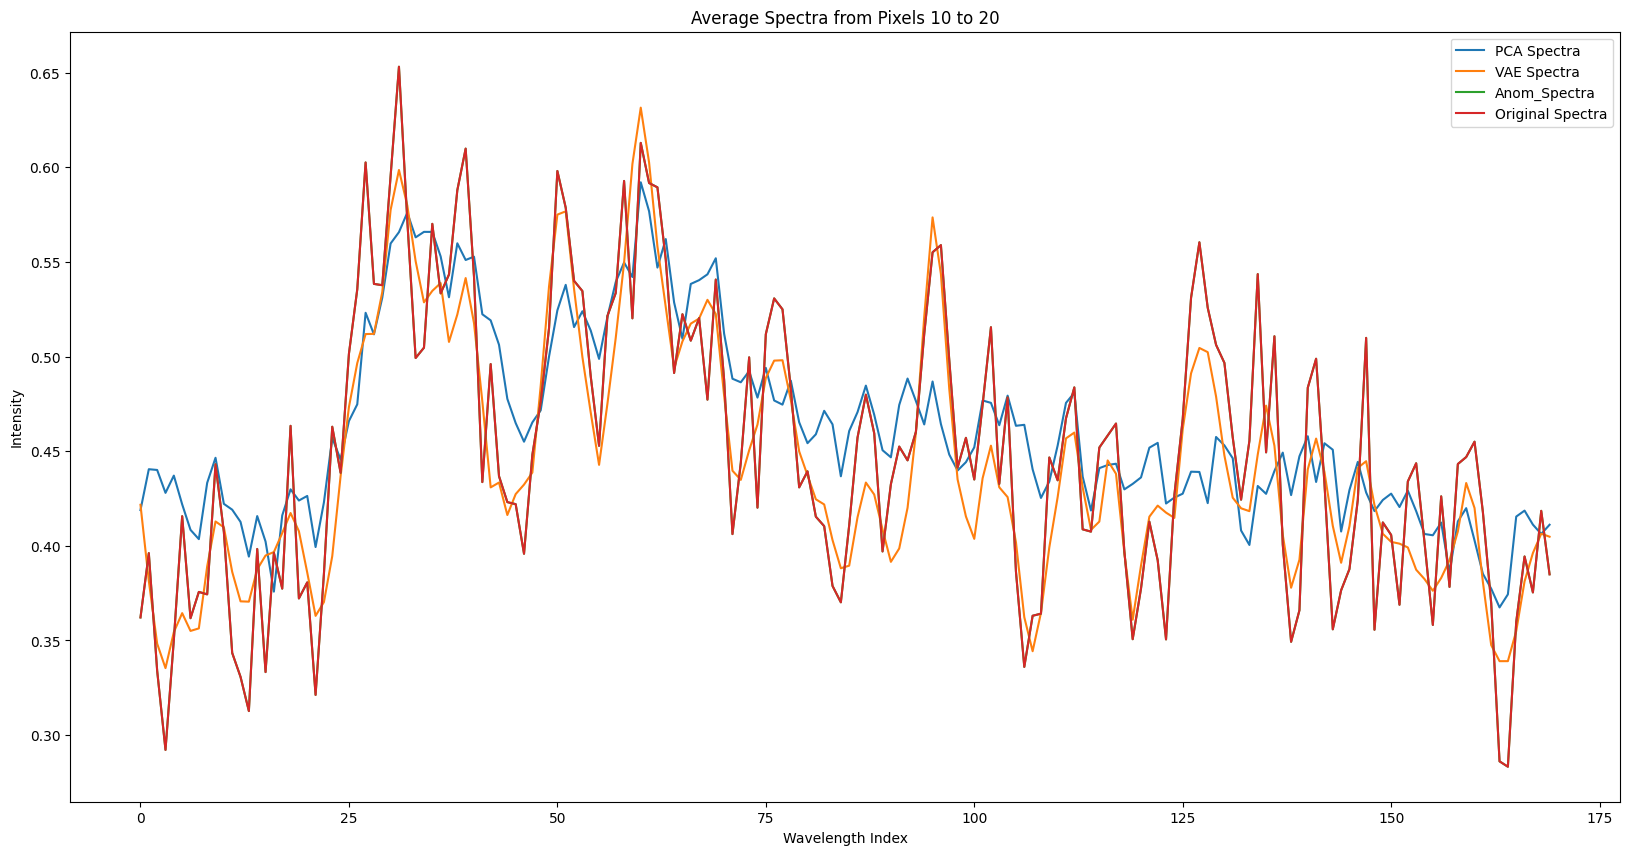

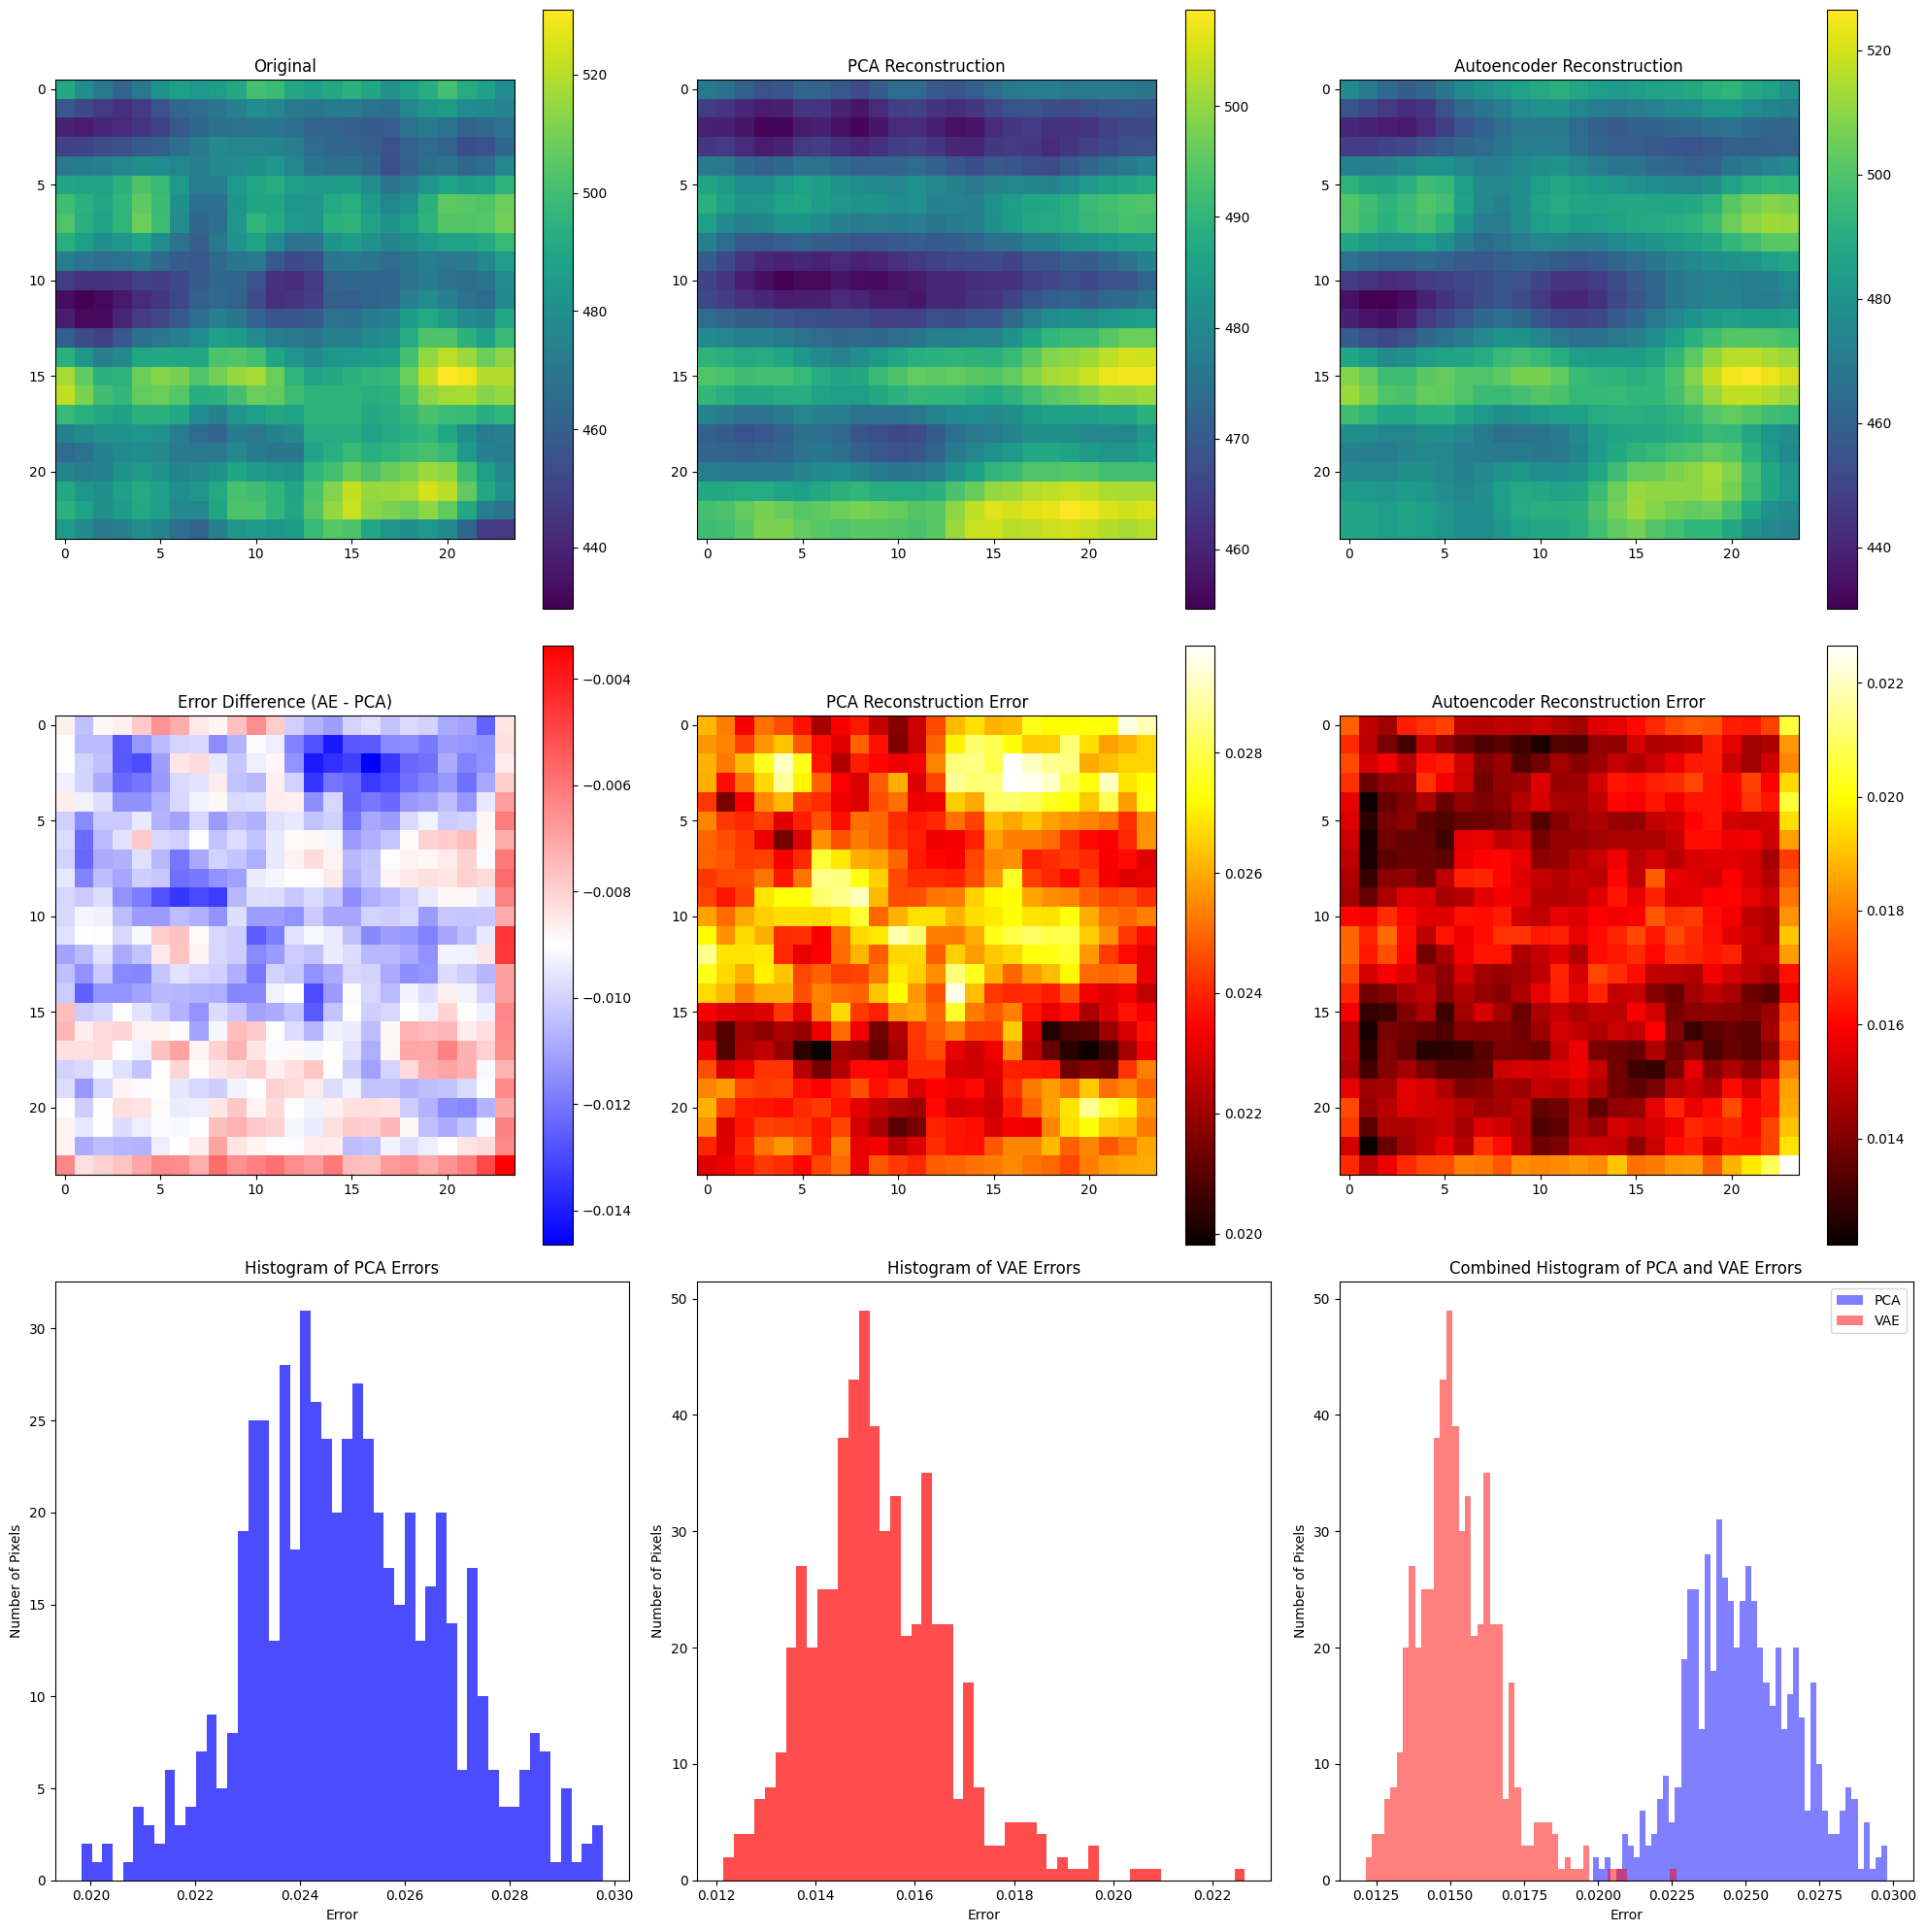

PCA Mean PEARSON Error: 0.0249
Autoencoder Mean PEARSON Error: 0.0153
Max PCA PEARSON Error: 0.0298
Max Autoencoder PEARSON Error: 0.0227


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from scipy.special import kl_div
from dtaidistance import dtw

def cosine_similarity(spec1, spec2):
    return 1 - cosine(spec1, spec2)

def pearson_correlation(spec1, spec2):
    return pearsonr(spec1, spec2)[0]

def kullback_leibler_divergence(spec1, spec2):
    # Add small constant to avoid division by zero
    spec1 = spec1 + 1e-10
    spec2 = spec2 + 1e-10
    return np.sum(kl_div(spec1, spec2))

def jensen_shannon_divergence(spec1, spec2):
    # Add small constant to avoid division by zero
    spec1 = spec1 + 1e-10
    spec2 = spec2 + 1e-10
    m = 0.5 * (spec1 + spec2)
    return 0.5 * (np.sum(kl_div(spec1, m)) + np.sum(kl_div(spec2, m)))

def dynamic_time_warping(spec1, spec2):
    return dtw.distance(spec1, spec2)

def compare_reconstruction_errors(model, input_data, sub_image_index, device='cuda', metric = 'pearson'):
    """
    Compare reconstruction errors between PCA and Autoencoder with raw error maps and histograms.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    pcau (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to visualize
    device (str): The device to run the model on ('cuda' or 'cpu')
    
    Returns:
    None (displays the plot)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]
    og_image = input_sub_image

    # Define your anomaly specifications
    anomaly_specs = [
        # ('cosmic_ray', 3, 1),  # 2 cosmic rays, each affecting 1 pixel
        ('peak_shift', 50, 1),  # 3 clusters of 4x4 pixels with peak shift
        # ('peak_broadening', 1, 3),  # 1 cluster of 3x3 pixels with peak broadening
        # ('noise_injection', 1, 10), 
        # ('multiple_scattering', 70, 1), 
        # ('background_slope', 1, 3), 
        # ('intensity_fluctuation', 1, 3), 
    ]

    # Inject the anomalies
    input_sub_image, anomaly_mask = inject_controlled_anomalies(input_sub_image, anomaly_specs)

    modified_input_data = input_data.copy()

    for i in range(0, 10): 
        temp_image, _ = inject_controlled_anomalies(input_data[i], anomaly_specs) 
        modified_input_data[i] = temp_image

    modified_input_data[sub_image_index] = input_sub_image

    # Plot the anomaly mask
    # plot_anomaly_mask(anomaly_mask, input_sub_image)

    # Perform PCA
    pca = PCA(n_components=30)
    flattened_data = modified_input_data.reshape(modified_input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    
    # Reconstruct using only the top 5 components
    top_components = pca_result[:, :5]
    reduced_components = pca.components_[:5, :]
    pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
    pca_reconstruction = pca_reconstruction.reshape(modified_input_data.shape)
    pca_sub_image = pca_reconstruction[sub_image_index]

    # Autoencoder reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        ae_reconstruction = reconstructed.squeeze().cpu().numpy()

    # Calculate average spectra from pixels 10 to 20
    # pca_avg = np.mean(pca_sub_image[0:23, 0:23, 350:520], axis=(0, 1))
    # ae_avg = np.mean(ae_reconstruction[0:23, 0:23, 350:520], axis=(0, 1))
    # input_avg = np.mean(input_sub_image[0:23, 0:23, 350:520], axis=(0, 1))
    # og_avg = np.mean(og_image[0:23, 0:23, 350:520], axis=(0, 1))

    pca_avg = pca_sub_image[12, 12, 350:520]
    ae_avg = ae_reconstruction[12, 12, 350:520]
    input_avg = input_sub_image[12, 12, 350:520]
    og_avg = og_image[12, 12, 350:520]

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the average spectra
    ax.plot(pca_avg, label="PCA Spectra")
    ax.plot(ae_avg, label="VAE Spectra")
    ax.plot(input_avg, label="Anom_Spectra")
    ax.plot(og_avg, label="Original Spectra")

    # Add legend and labels
    ax.legend()
    ax.set_xlabel("Wavelength Index")
    ax.set_ylabel("Intensity")
    ax.set_title("Average Spectra from Pixels 10 to 20")

    # Choose the similarity measure
    if metric == 'cosine':
        similarity_func = cosine_similarity
    elif metric == 'pearson':
        similarity_func = pearson_correlation
    elif metric == 'kl':
        similarity_func = kullback_leibler_divergence
    elif metric == 'js':
        similarity_func = jensen_shannon_divergence
    elif metric == 'dtw':
        similarity_func = dynamic_time_warping
    else:
        raise ValueError("Invalid metric. Choose from 'cosine', 'pearson', 'kl', 'js', or 'dtw'.")

    # Calculate reconstruction errors using the chosen similarity measure
    pca_error = np.zeros_like(input_sub_image[:,:,0])
    ae_error = np.zeros_like(input_sub_image[:,:,0])
    
    for i in range(input_sub_image.shape[0]):
        for j in range(input_sub_image.shape[1]):
            pca_error[i,j] = similarity_func(input_sub_image[i,j], pca_sub_image[i,j])
            ae_error[i,j] = similarity_func(input_sub_image[i,j], ae_reconstruction[i,j])

    # For similarity measures where higher values indicate more similarity, invert the error
    if metric in ['cosine', 'pearson']:
        pca_error = 1 - pca_error
        ae_error = 1 - ae_error

    # Calculate error difference
    error_diff = ae_error - pca_error

    # Plotting
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    # Original image
    im_orig = axs[0, 0].imshow(np.sum(input_sub_image, axis=-1), cmap='viridis')
    axs[0, 0].set_title("Original")
    plt.colorbar(im_orig, ax=axs[0, 0])

    # PCA reconstruction
    im_pca = axs[0, 1].imshow(np.sum(pca_sub_image, axis=-1), cmap='viridis')
    axs[0, 1].set_title("PCA Reconstruction")
    plt.colorbar(im_pca, ax=axs[0, 1])

    # Autoencoder reconstruction
    im_ae = axs[0, 2].imshow(np.sum(ae_reconstruction, axis=-1), cmap='viridis')
    axs[0, 2].set_title("Autoencoder Reconstruction")
    plt.colorbar(im_ae, ax=axs[0, 2])

    # PCA error map
    im_pca_err = axs[1, 1].imshow(pca_error, cmap='hot')
    axs[1, 1].set_title("PCA Reconstruction Error")
    plt.colorbar(im_pca_err, ax=axs[1, 1])

    # Autoencoder error map
    im_ae_err = axs[1, 2].imshow(ae_error, cmap='hot')
    axs[1, 2].set_title("Autoencoder Reconstruction Error")
    plt.colorbar(im_ae_err, ax=axs[1, 2])

    # Error difference (AE - PCA)
    im_diff = axs[1, 0].imshow(error_diff, cmap='bwr')
    axs[1, 0].set_title("Error Difference (AE - PCA)")
    plt.colorbar(im_diff, ax=axs[1, 0])

    # Histogram of PCA errors
    axs[2, 0].hist(pca_error.flatten(), bins=50, alpha=0.7, color='blue')
    axs[2, 0].set_title("Histogram of PCA Errors")
    axs[2, 0].set_xlabel("Error")
    axs[2, 0].set_ylabel("Number of Pixels")

    # Histogram of VAE errors
    axs[2, 1].hist(ae_error.flatten(), bins=50, alpha=0.7, color='red')
    axs[2, 1].set_title("Histogram of VAE Errors")
    axs[2, 1].set_xlabel("Error")
    axs[2, 1].set_ylabel("Number of Pixels")

    # Combined histogram of PCA and VAE errors
    axs[2, 2].hist(pca_error.flatten(), bins=50, alpha=0.5, color='blue', label='PCA')
    axs[2, 2].hist(ae_error.flatten(), bins=50, alpha=0.5, color='red', label='VAE')
    axs[2, 2].set_title("Combined Histogram of PCA and VAE Errors")
    axs[2, 2].set_xlabel("Error")
    axs[2, 2].set_ylabel("Number of Pixels")
    axs[2, 2].legend()

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"PCA Mean {metric.upper()} Error: {np.mean(pca_error):.4f}")
    print(f"Autoencoder Mean {metric.upper()} Error: {np.mean(ae_error):.4f}")
    print(f"Max PCA {metric.upper()} Error: {np.max(pca_error):.4f}")
    print(f"Max Autoencoder {metric.upper()} Error: {np.max(ae_error):.4f}")


# Usage example:
compare_reconstruction_errors(model, dataset, sub_image_index=19, device="cuda")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
import torch

def large_scale_anomaly_test(input_data, model, max_affected_subimages, anomalies_per_subimage, anomaly_type, threshold, device='cuda'):
    """
    Perform large-scale testing of anomaly detection with progressive sub-image corruption.
    
    Args:
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    model (torch.nn.Module): The trained VAE model
    max_affected_subimages (int): Maximum number of sub-images to affect
    anomalies_per_subimage (int): Number of anomalies to inject into each sub-image
    anomaly_type (str): Type of anomaly to inject
    threshold (float): Threshold for considering a pixel as anomalous
    device (str): The device to run the model on ('cuda' or 'cpu')
    
    Returns:
    dict: Results for PCA and VAE
    """
    results = {'pca': [], 'vae': []}
    num_subimages, height, width, energy_channels = input_data.shape
    
    for num_affected in tqdm(range(1, min(max_affected_subimages, num_subimages) + 1), desc="Affecting sub-images"):
        # Create a copy of the input data
        anomalous_data = input_data.copy()
        all_anomaly_masks = np.zeros((num_subimages, height, width), dtype=bool)
        
        # Inject anomalies into the first 'num_affected' sub-images
        for i in range(num_affected):
            anomaly_specs = [(anomaly_type, anomalies_per_subimage, 1)]  # 1x1 anomalies
            anomalous_sub_image, anomaly_mask = inject_controlled_anomalies(anomalous_data[i], anomaly_specs)
            anomalous_data[i] = anomalous_sub_image
            all_anomaly_masks[i] = anomaly_mask > 0
        
        # Perform PCA
        pca = PCA(n_components=30)
        flattened_data = anomalous_data.reshape(num_subimages, -1)
        pca_result = pca.fit_transform(flattened_data)
        pca_reconstruction = pca.inverse_transform(pca_result[:, :5]).reshape(anomalous_data.shape)
        
        # Perform VAE reconstruction
        vae_reconstruction = np.zeros_like(anomalous_data)
        for i in range(num_subimages):
            with torch.no_grad():
                input_tensor = torch.tensor(anomalous_data[i]).unsqueeze(0).unsqueeze(0).float().to(device)
                reconstructed, _, _ = model(input_tensor)
                vae_reconstruction[i] = reconstructed.squeeze().cpu().numpy()
        
        # Calculate errors
        pca_error = np.sum(np.abs(anomalous_data - pca_reconstruction), axis=-1)
        vae_error = np.sum(np.abs(anomalous_data - vae_reconstruction), axis=-1)
        
        # Detect anomalies
        pca_detected = pca_error > threshold
        vae_detected = vae_error > threshold
        
        # Calculate metrics
        for method, detected in [('pca', pca_detected), ('vae', vae_detected)]:
            tp = np.sum((detected == 1) & (all_anomaly_masks == 1))
            fp = np.sum((detected == 1) & (all_anomaly_masks == 0))
            fn = np.sum((detected == 0) & (all_anomaly_masks == 1))
            total_pixels = np.prod(all_anomaly_masks.shape)
            
            results[method].append({
                'num_affected_subimages': num_affected,
                'tp': tp / total_pixels * 100,
                'fp': fp / total_pixels * 100,
                'fn': fn / total_pixels * 100
            })
    
    return results

# Usage example:
max_affected_subimages = 20
anomalies_per_subimage = 20
anomaly_type = 'peak_shift'
threshold = 65
results = large_scale_anomaly_test(dataset, model, max_affected_subimages, anomalies_per_subimage, anomaly_type, threshold, device="cuda")

# Plot results
def plot_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Anomaly Detection Performance')
    
    for ax, method in zip((ax1, ax2), ('pca', 'vae')):
        num_affected = [r['num_affected_subimages'] for r in results[method]]
        tp = [r['tp'] for r in results[method]]
        fp = [r['fp'] for r in results[method]]
        fn = [r['fn'] for r in results[method]]
        
        ax.plot(num_affected, tp, label='True Positives', marker='o')
        ax.plot(num_affected, fp, label='False Positives', marker='s')
        ax.plot(num_affected, fn, label='False Negatives', marker='^')
        
        ax.set_xlabel('Number of Affected Sub-images')
        ax.set_ylabel('Percentage of Pixels')
        ax.set_title(f'{method.upper()} Performance')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# plot_results(results)

Affecting sub-images:   0%|          | 0/20 [00:00<?, ?it/s]

Affecting sub-images:   0%|          | 0/20 [00:03<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 30 is different from 5)